# Using GeoPandas to compute "pond connectivity"
One of our students has dug up a method for computing how connected ponds are in a landscape. This method involves computing the total length of "to" pond edge within a set distance of a given "from" pond. It also involves computing a convex hull around this segment of "to" pond edge. Here, we show how GeoPandas can do this from a shapefile of ponds. 

### Workflow
1. Import pond shapefile into a geodataframe
 1. Explore the geodataframe(table, plot, summary)
1. Isolate a single "from" pond into a new geoseries
 1. Compute a 200m buffer this pond
1. Isolate all other "to" ponds into a new geodataframe
1. Compute intersection of buffered ponds with the original pond
 1. Calculate the total edge falling within the buffer (meters)
1. Compute convex hulls around the intersecting edge
 1. Calculate the total area of these convex_hulls

## 1. Read in the shapefile and explore the data

In [1]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function)
import os
import json
import psycopg2

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point, linestring, Polygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

data_pth = "./data"

Read the shapefile of ponds into a geodataframe and examine the dataframe

In [2]:
#Read in "DurhamKorstian_ponds_noriverine.shp" as a geodataframe
gdfPonds = gpd.read_file(os.path.join(data_pth,'DurhamKorstian_ponds_noriverine.shp'))

In [3]:
#Examine the geodataframe in tabular format
gdfPonds.head()

,ATTRIBUTE,WETLAND_TY,ACRES,SHAPE_Leng,SHAPE_Area,OBJECTID,Permanent_,FDate,Resolution,GNIS_ID,...,Elevation,ReachCode,FType,FCode,Visibility,Type,Notes,Compt,Shape_Le_1,geometry
0,PFO1/4C,Freshwater Forested/Shrub Wetland,8.419918,787.536547,34074.199901,0,None,None,0,None,...,0.0,None,0,0,0,None,None,None,0.0,POLYGON Z ((1999384.392544852 811804.966771061...
1,PFO1A,Freshwater Forested/Shrub Wetland,2.053384,404.338933,8309.751132,0,None,None,0,None,...,0.0,None,0,0,0,None,None,None,0.0,POLYGON Z ((1999385.374279817 811763.770449683...
2,PFO1A,Freshwater Forested/Shrub Wetland,17.544769,3026.010320,71001.162357,0,None,None,0,None,...,0.0,None,0,0,0,None,None,None,0.0,POLYGON Z ((1985226.910630648 815363.370690486...
3,PFO1A,Freshwater Forested/Shrub Wetland,5.528421,969.683826,22372.725863,0,None,None,0,None,...,0.0,None,0,0,0,None,None,None,0.0,POLYGON Z ((2005024.999399121 813495.713272036...
4,PFO1A,Freshwater Forested/Shrub Wetland,0.387059,531.574885,1566.373310,0,None,None,0,None,...,0.0,None,0,0,0,None,None,None,0.0,POLYGON Z ((2004818.309717336 814471.328649018...


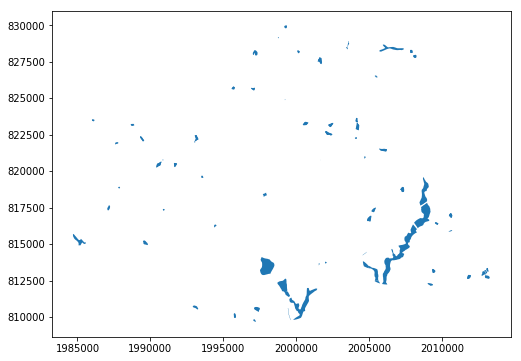

In [4]:
#Examine the geodataframe in spatial format
gdfPonds.plot(figsize=(15,6));

In [5]:
#Show how many features are in the geodataframe
len(gdfPonds)

115

In [6]:
#Show the projection of the dataframe
gdfPonds.crs

{'proj': 'lcc',
 'lat_1': 34.33333333333334,
 'lat_2': 36.16666666666666,
 'lat_0': 33.75,
 'lon_0': -79,
 'x_0': 609601.2199999997,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

## 2. Create a new dataset off ponds buffered 200m

* First, we copy the original dataframe. Specifying `deep=True` indicates that we want a completely new dataframe, not just a new representation of the same dataframe. 

In [7]:
#First copy the original dataframe (deep creates a "true" copy)
gdfBufferedPonds = gdfPonds.copy(deep=True)

* Next, we update the values in the geometry column (i.e., the GeoSeries) with a 200 m buffer of the original polygons

In [8]:
#Now update the geometry in the copied dataframe to be buffered values
gdfBufferedPonds['geometry'] = gdfBufferedPonds['geometry'].buffer(200)

* Let's take a look and see what we did

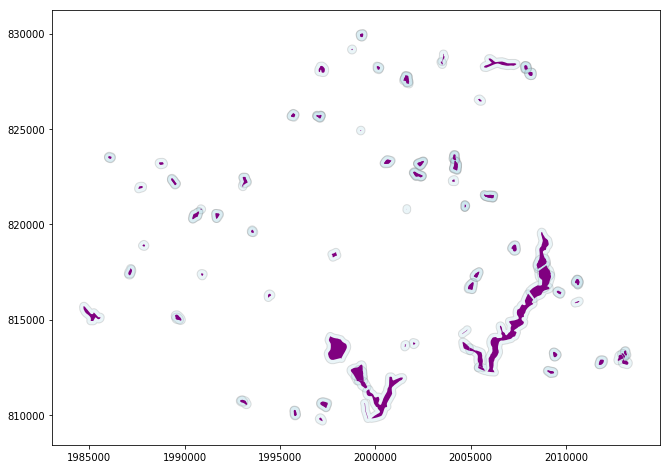

In [9]:
#Plot them, to make sure they look right
fig, ax1 = plt.subplots(1, figsize=(16,8))  #Creates the plot canvas with one set of axes (i.e. one plot)
gdfBufferedPonds.plot(ax=ax1,               #Adds the buffered featured to the axis
                      facecolor='lightblue',  #Features in light blue
                      edgecolor='gray',       #Outline in gray
                      alpha=0.25              #25% opaque
                     ) 
gdfPonds.plot(ax=ax1,facecolor='purple');   #Adds the original ponds to the on top of the plot

---
*Things are looking good. So let's now do our analysis. Here's the plan:*
* Isolate a single pond from the buffered ponds dataframe (`fromPond`)
* Create a dataframe of all the other ponds (`toPonds`)
* Find the total edge in the `toPonds` dataset within the buffer distance of the `fromPond`
 * To do this, we need to convert the `toPonds` from a polygon to a polyline
 * Then we intersect the buffered `fromPond` geometry and the `toPonds` lines
* Finally, we want to compute a convex hull around the `toPonds` edge found within the selected distance.

## 3. Construct new geodataframes: a single pond (buffered), and all the other ponds
* To create the `fromPond` and `toPonds` datasets, we'll first create two masks - one of a selected pond and one of everything but the selected pond. To start, we'll set the 'fromPond' to be the second record (index = 1).

In [10]:
x = 1 #x will represent the index of a selected pond.

#Create masks of (1) just a single pond and (2) all other ponds
fromPond_mask = gdfPonds.index == x
toPonds_mask = gdfPonds.index != x

#Apply the masks to create new geodataframes of the single pond,
# the single pond buffered, and all other ponds
fromPond = gdfPonds[fromPond_mask]
fromPond_200m = gdfBufferedPonds[fromPond_mask]
toPonds= gdfPonds[toPonds_mask]

* Now, let's look at our new geodataframes. We'll create a new canvas (`fig` and single plot `ax1`), then add three layers in order: first all the "to ponds" in blue, then on top of that the bufferd "from pond" in light blue, and finally the "from pond" itself in orange.

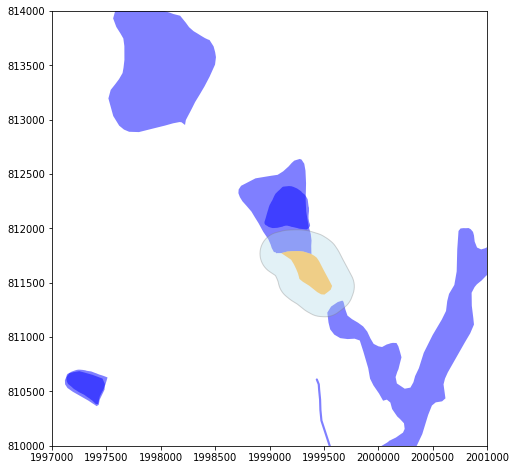

In [11]:
#Plot buffered ponds, showing ours as red
fig, ax1 = plt.subplots(1, figsize=(8, 8))
toPonds.plot(ax=ax1, facecolor='blue',alpha=0.50)
fromPond_200m.plot(ax=ax1, facecolor='lightblue',edgecolor='gray',alpha=0.35)
fromPond.plot(ax=ax1, facecolor='orange',alpha=0.45)
#Zoom into the shape
plt.xlim((1997000,2001000))
plt.ylim((810000,814000));

### 4. Convert "toPonds" polygons to lines
What we want to compute is how much "to" pond border is within the buffer distance of our "from" pond, so we need to convert the 'toPonds' dataset from a polygon to a polyline dataset. We do this by applying the `boundary` function to the geometry values in the dataset. We'll be overwriting the dataset's geometry values, so we'll make a copy and then revise the geometry values. 

In [12]:
#Create a new geodataframe of just the selected pond's edges (convert to polyline)
toPondEdges = fromPond.copy(deep=True) 
toPondEdges['geometry'] = toPondEdges['geometry'].boundary
toPondEdges.type

1    LineString
dtype: object

## 5. Select to-pond boundaries falling within the from-pond buffer 
We'll use GeoPanda's [**overlay operations**](http://geopandas.org/set_operations.html) to intersect the to-pond boundaries falling within the from-pond's buffer.

In [13]:
#Create a new geodataframe of just the lines clipped by the pond buffer
clippedPond = gpd.overlay(fromPond,toPondEdges,how='intersection')

TypeError: overlay only takes GeoDataFrames with (multi)polygon  geometries.

* *Turns out the `overlay` function only works with two polygon feature collections.* So as a workaround, we'll slightly buffer out to-pond edges to make them polygons.

In [14]:
#Conver the geometry of the toPondEdges to a polygon
toPondEdgesPoly = toPondEdges.copy(deep=True)
toPondEdgesPoly['geometry'] = toPondEdgesPoly.buffer(1)

In [15]:
#Try again, but with the toPondEdgesPoly
clippedPond = gpd.overlay(fromPond,toPondEdgesPoly,how='intersection')

## 6. Compute the convex hull around the intersected pond borders
Part of the analysis consists of computing convex hulls from the nearby pond edges. This is super easy to do with GeoPandas

In [16]:
#Create a new geodataframe consisting of the convex hulls of the nearby edges
clippedHulls = clippedPond.copy(deep='True')
clippedHulls['geometry'] = clippedHulls['geometry'].convex_hull

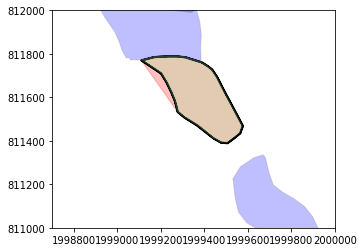

In [17]:
#And plot the outputs
f, ax = plt.subplots(1)
clippedHulls.plot(ax=ax,facecolor='red',edgecolor='red',alpha=0.25)
clippedPond.plot(ax=ax,edgecolor='black',linewidth=2)
fromPond.plot(ax=ax,facecolor='lightgreen',alpha=0.25)
toPonds.plot(ax=ax, facecolor='blue',edgecolor='gray',alpha=0.25)
plt.xlim((1998700,2000000))
plt.ylim((811000,812000));

## 7. Computing the results: 
So, how "connected" is Pond 1? We have two metrics to answer this:
* The length of the nearby edges (however this is actually the perimeter of the clipped edge polys!)
* The area of the convex hulls

In [18]:
#Print the sum of lenght and area of the respective geometries
print("Total nearby edge: {:.0f} m".format(clippedPond.length.sum()))
print("Total nearby edge convex hull area {:.0f} m2".format(clippedHulls.area.sum()))

Total nearby edge: 2647 m
Total nearby edge convex hull area 96762 m2


## Recap
While not perfect (we had to convert our border back to a polygon), this exercise does illustrate key uses of GeoPandas and the powerful spatial analysis it adds to Pandas. If we wanted to, it wouldn't take much to extend this analysis to compute the total nearby edge and edge convex hull area for all ponds in our dataset: we'd just have to streamline our code and place it into a loop...